# DATA5000 Workshop 8: YOLOV8 SUPERVISION DETECTS OBJECTS IN VIDEOS

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Preliminaries

pytorch is developed by facebook and torchlight is
Extension library for computer vision in PyTorch

In [2]:
# install pytorch
%pip install torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [5]:
# import torch
import torch
from torch import nn # neural network
import torch.nn.functional as F # alias

## Check for GPU availability - speeds up video and image recognition and other AI tasks

In [6]:
# check for GPU availability - only works on Google Colab
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-ba160944-b46b-04cd-3c2f-aaf0fcf537da)


!nvidia-smi -L is the company name . name of the GPU that we are using i.e, T4 GPU


In [7]:
!nvidia-smi -q


==============NVSMI LOG==============

Timestamp                                 : Tue May  6 01:57:27 2025
Driver Version                            : 550.54.15
CUDA Version                              : 12.4

Attached GPUs                             : 1
GPU 00000000:00:04.0
    Product Name                          : Tesla T4
    Product Brand                         : NVIDIA
    Product Architecture                  : Turing
    Display Mode                          : Enabled
    Display Active                        : Disabled
    Persistence Mode                      : Disabled
    Addressing Mode                       : None
    MIG Mode
        Current                           : N/A
        Pending                           : N/A
    Accounting Mode                       : Disabled
    Accounting Mode Buffer Size           : 4000
    Driver Model
        Current                           : N/A
        Pending                           : N/A
    Serial Number                 

In [9]:
!nvidia-smi # temperature and power of GPU

Tue May  6 01:59:18 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [10]:
!lscpu | grep 'Core(s) each processor has/per socket:'

In [11]:
!lscpu | grep 'Number of threads/core:'

In [12]:
!free -h --si | awk  '/Mem:/{print $2}'

12G


# Set HOME folder to store videos

In [14]:
# create folder for data
import os
HOME = os.getcwd() # cwd = current working directory
print(HOME)

/content


In [17]:
!mkdir {HOME}/videos # make directory

mkdir: cannot create directory ‘/content/videos’: File exists


In [18]:
%cd {HOME}/videos

# get videos of traffic conditions
!wget -q https://s3.ap-southeast-2.wasabisys.com/data5000/pexels_videos_1860079_traffic.mp4

/content/videos


In [36]:
# change the directory or location of the video path
SOURCE_VIDEO_PATH = f"{HOME}/2103099-uhd_3840_2160_30fps.mp4"
SOURCE_VIDEO_PATH

'/content/2103099-uhd_3840_2160_30fps.mp4'

## Install Ultralytics

In [25]:
!pip install ultralytics # download any version of YOLO

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics 8.3.127 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 41.1/112.6 GB disk)


# Install Supervision

In [27]:
!pip install supervision # make blocks and labels where we make the supervision

from IPython import display
display.clear_output()

# we are importing supervision aliased as superviz
import supervision as superviz
print("supervision.__version__:", superviz.__version__)

supervision.__version__: 0.25.1


# Object detection in videos

- xyxy `(np.ndarray)`: An array of shape `(n, 4)` containing the bounding boxes coordinates in format `[x1, y1, x2, y2]`
- mask: `(Optional[np.ndarray])`: An array of shape `(n, W, H)` containing the segmentation masks.
- confidence `(Optional[np.ndarray])`: An array of shape `(n,)` containing the confidence scores of the detections.
- class_id `(Optional[np.ndarray])`: An array of shape `(n,)` containing the class ids of the detections.
- tracker_id `(Optional[np.ndarray])`: An array of shape `(n,)` containing the tracker ids of the detections.

mask= 4 points of bounding box (daily scenario is for object detection and segmentation is for the exact/ precision area or in the heath sectors.)

class_id cannot change whereas tracker_id can be changed.

In [30]:
MODEL = "yolov8x.pt" # 8x is the version


In [29]:
from ultralytics import YOLO

model = YOLO(MODEL)
model.fuse()

100%|██████████| 131M/131M [00:00<00:00, 339MB/s]


YOLOv8x summary (fused): 112 layers, 68,200,608 parameters, 0 gradients, 257.8 GFLOPs


In [31]:
# dict maping class_id to class_name
CLASS_NAMES_DICT = model.model.names

# class_ids of interest - car, motorcycle, bus and truck
selected_classes = [2, 3, 5, 7]

In [32]:
import supervision as superviz
import numpy as np

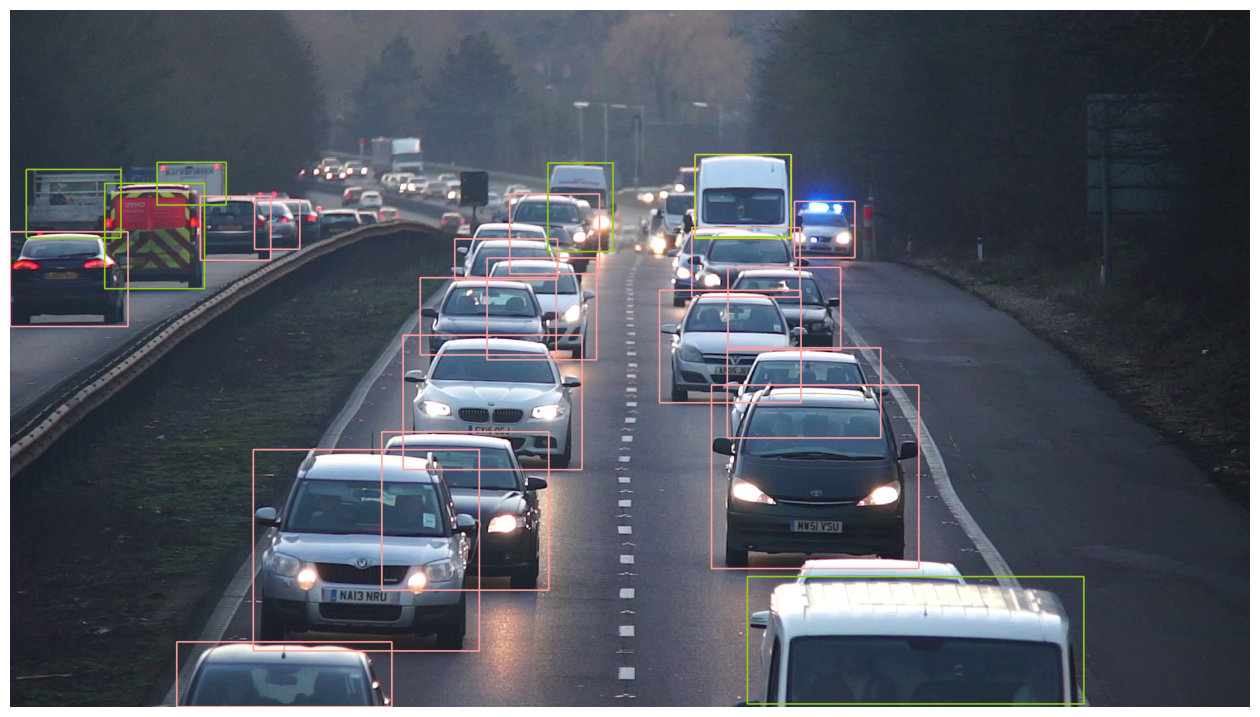

In [37]:
# create frame generator
frame_generator = superviz.get_video_frames_generator(SOURCE_VIDEO_PATH)


# create instance of BoxAnnotator
box_annotator = superviz.BoxAnnotator(thickness=4)


# acquire first video frame
iterator = iter(frame_generator)


frame = next(iterator)

# model prediction on single frame and conversion to supervision Detections
results = model(frame, verbose=False)[0]

# convert to Detections
detections = superviz.Detections.from_ultralytics(results)

# only take class id from selected_classes define above
detections = detections[np.isin(detections.class_id, selected_classes)]


# format custom labels

labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for confidence, class_id in zip(detections.confidence, detections.class_id)
]


# annotate and display frame
anotated_frame=box_annotator.annotate(scene=frame, detections=detections)

%matplotlib inline
superviz.plot_image(anotated_frame, (16,16))

# Great - so we know we can detect vehicales etc...in a frame of video i.e., an image. Now let us extend this to the entire video

# Predict and label the entire video clip

In [38]:
!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

"""install byte-track"""

# Commented out IPython magic to ensure Python compatibility.
# %cd {HOME}
!git clone https://github.com/ifzhang/ByteTrack.git
!cd ByteTrack && pip3 install -q -r requirements.txt
!cd ByteTrack && python3 setup.py -q develop
!pip install -q cython_bbox
!pip install -q onemetric

from IPython import display
display.clear_output()

bytetrack= tracking algorithm for the complete analysis.

In [39]:
!pip install roboflow==0.2.34

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 6.5 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=e2142c43156a72ae9d5cd6a11cf8ebd2ab7c5a7e342b1f633f1478bc6315fdb3
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.2.3
    Uninstalling pyparsing-3.2.3:
      Successfully uninstalled pyparsing-3.2.3
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninst

In [1]:
!pip install supervision==0.1.0
import supervision
print("supervision.__version__:", supervision.__version__)

from supervision.draw.color import ColorPalette
from supervision.geometry.dataclasses import Point
from supervision.video.dataclasses import VideoInfo
from supervision.video.source import get_video_frames_generator
from supervision.video.sink import VideoSink
from supervision.notebook.utils import show_frame_in_notebook
from supervision.tools.detections import Detections, BoxAnnotator
from supervision.tools.line_counter import LineCounter, LineCounterAnnotator

from typing import List

import numpy as np



  Attempting uninstall: supervision
    Found existing installation: supervision 0.25.1
    Uninstalling supervision-0.25.1:
      Successfully uninstalled supervision-0.25.1
supervision.__version__: 0.1.0


In [2]:
import sys

import os
HOME = os.getcwd()
print(HOME)
sys.path.append(f"{HOME}/ByteTrack")


!pip install loguru
!pip install tqdm
!pip install lap
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass
import tqdm

/content
  Using cached loguru-0.7.3-py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 3.0 MB/s eta 0:00:00
  Using cached lap-0.5.12-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.2 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 28.3 MB/s eta 0:00:00


In [3]:
# converts Detections into format that can be consumed by match_detections_with_tracks function
def detections2boxes(detections: Detections) -> np.ndarray:
    return np.hstack((
        detections.xyxy,
        detections.confidence[:, np.newaxis]
    ))


# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)


# matches our bounding boxes with predictions
def match_detections_with_tracks(
    detections: Detections,
    tracks: List[STrack]
) -> Detections:
    if not np.any(detections.xyxy) or len(tracks) == 0:
        return np.empty((0,))

    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detections.xyxy)
    track2detection = np.argmax(iou, axis=1)

    tracker_ids = [None] * len(detections)

    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].track_id

    return tracker_ids


In [4]:
@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

In [8]:
#SOURCE_VIDEO_PATH = f"{HOME}/videos/pexels_videos_1860079_traffic.mp4"
SOURCE_VIDEO_PATH

generator = get_video_frames_generator(SOURCE_VIDEO_PATH)

VideoInfo.from_video_path(SOURCE_VIDEO_PATH)


NameError: name 'SOURCE_VIDEO_PATH' is not defined

In [ ]:
# create BYTETracker instance
byte_tracker = BYTETracker(BYTETrackerArgs())


# create VideoInfo instance
video_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)

# create LineZone instance, it is previously called LineCounter class
#line_counter = LineCounter(start=LINE_START, end=LINE_END)

# create instance of BoxAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)

# create instance of TraceAnnotator
#trace_annotator = superviz.TraceAnnotator(thickness=4, trace_length=50)

# create LineZoneAnnotator instance, it is previously called LineCounterAnnotator class
#line_zone_annotator = superviz.LineZoneAnnotator(thickness=4, text_thickness=4, text_scale=2)

# define call back function to be used in video processing
def callback(frame: np.ndarray, index:int) -> np.ndarray:

    # model prediction on single frame and conversion to supervision detections
    results = model(frame, verbose=False)[0]
    detections = superviz.Detections.from_ultralytics(results)

    # only consider class id from selected_classes define above
    detections = detections[np.isin(detections.class_id, selected_classes)]

    # tracking detections
    detections = byte_tracker.update_with_detections(detections)

    labels = [
        f"#{tracker_id} {model.model.names[class_id]} {confidence:0.2f}"
        for _, _, confidence, class_id, tracker_id
        in detections
    ]

    annotated_frame = trace_annotator.annotate(
        scene=frame.copy(),
        detections=detections
    )

    annotated_frame=box_annotator.annotate(
        scene=annotated_frame,
        detections=detections,
        labels=labels)

    # update line counter
    line_zone.trigger(detections)


    # return frame with box and line annotated result
    return  line_zone_annotator.annotate(annotated_frame, line_counter=line_zone)

    # process the whole video
superviz.process_video(
    source_path = SOURCE_VIDEO_PATH,
    target_path = TARGET_VIDEO_PATH,
    callback=callback
)

In [ ]:
from IPython.display import HTML

HTML("""
    <video width="320" height="240" controls>
        <source src={SOURCE_VIDEO_PATH} type="video/mp4">
    </video>
""")

In [ ]:
from IPython.display import HTML

HTML("""
    <video width="320" height="240" controls>
        <source src={TARGET_VIDEO_PATH} type="video/mp4">
    </video>
""")